In [ ]:
import numpy as np
from numba import njit
import numba as nb

In [ ]:
@njit
def internal_mean(arr):
    '''
    same as np.mean(arr, axis=1), but jitted
    since numba does not support kwargs in np.mean
    '''
    assert len(arr.shape) == 3
    assert arr.shape[1] == 2

    out = np.zeros((arr.shape[0], arr.shape[2]), dtype=arr.dtype)
    for i, (v1, v2) in enumerate(arr):
        out[i] = (v1 + v2) / 2

    return out


In [ ]:
from rmsd import kabsch_rotate
from python_functions import rmsd_and_max
from algebra import internal_mean, vec_mean

@njit
def rmsd_and_max_jit(P, Q):
    '''
    ** ADAPTED FROM THE PYTHON RMSD LIBRARY **

    Rotate matrix P unto Q using Kabsch algorithm and calculate the RMSD.
    Returns RMSD and max deviation.

    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    rmsd : float
        root-mean squared deviation
    max_delta : float
        maximum deviation value
    '''

    Q -= vec_mean(Q)
    P -= vec_mean(P)
    P = kabsch_rotate_jit(P, Q)

    diff = Q - P
    rmsd = np.sqrt((diff * diff).sum() / len(diff))
    max_delta = np.max(internal_mean(diff))

    return rmsd, max_delta

@njit
def kabsch_rotate_jit(P, Q):
    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return np.dot(P, U)


In [ ]:
from algebra import internal_mean

x = np.random.rand(10, 100, 3)
a = np.mean(x, axis=1)
b = internal_mean(x)
np.allclose(a,b)

In [ ]:
from cclib.io import ccread
data = ccread(r'C:\Users\ehrma\Desktop\cool_structs\Ph2PAla\Ph2PAla_confs_opt.xyz')
data.atomcoords.shape

In [ ]:
r = [(i,rmsd_and_max(data.atomcoords[0], data.atomcoords[i])) for i in range(len(data.atomcoords))]
r

In [ ]:
print(f'keep {len([i for i in r if i[1][0] < 2])}/{len(r)}')

In [ ]:
from algebra import get_inertia_moments
from pt import pt
masses = np.array([pt[i].mass for i in data.atomnos])
r = [(i,get_inertia_moments(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
r

In [ ]:
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

In [ ]:
from algebra import center_of_mass
def MOI(coords, masses):
    coords -= center_of_mass(coords, masses)
    return np.sum([masses[i]*np.linalg.norm(coords[i])**2 for i in range(len(coords))])

MOI(data.atomcoords[0], masses)

In [ ]:
r = [(i,MOI(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

In [ ]:
import networkx as nx
edges = [(7, 7), (7, 9), (7, 13), (7, 6), (9, 9), (9, 10), (9, 31), (10, 10), (10, 11), (10, 32), (11, 11), (11, 12), (11, 33), (12, 12), (12, 13), (12, 34), (13, 13), (13, 35), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True)

In [ ]:
d = {}
for i in (31,32,33,34,35):
    d[i] = 1
for i in (7,9,10,11,12,13):
    d[i] = 6
d[6] = 15
d[345] = 45
nx.set_node_attributes(G, d, 'atomnos')
# G.nodes[6]['atomnos']
nx.get_node_attributes(G, 'atomnos')

In [ ]:
import os
os.chdir(r'C:\Users\ehrma\Desktop\Coding\TSCoDe')
from graph_manipulations import get_sp_n
for node in G.nodes:
    print(f'{node}: sp{get_sp_n(node, G)}')

In [ ]:
from tscode.python_functions import prune_conformers, fast_score, rmsd_and_max
from tscode.optimization_methods import prune_enantiomers
from tscode.algebra import get_inertia_moments
from tscode.pt import pt
from cclib.io import ccread
import numpy as np
import networkx as nx
import numba as nb

def old(structures, atomnos):
    for k in (5000, 2000, 1000, 500, 200, 100, 50, 20, 10, 5, 2, 1):
        if k == 1 or 5*k < len(structures):
            structures, mask = prune_conformers(structures, atomnos, max_rmsd=2, max_delta=2, k=k)
    return structures, mask

def new(structures, atomnos):
    return new_prune_conformers(structures, atomnos, max_rmsd=2, max_delta=2)

def new_prune_conformers(structures, atomnos, max_rmsd=0.5, max_delta=None):
    '''
    Group structures into k subgroups and remove the similar ones.
    Similarity occurs for structures with both RMSD < max_rmsd and
    maximum deviation < max_delta.
    '''
    # xxx=0
    max_delta = max_rmsd * 2 if max_delta is None else max_delta

    heavy_atoms = (atomnos != 1)
    heavy_structures = np.array([structure[heavy_atoms] for structure in structures])

    cache_set = set()
    final_mask = np.ones(structures.shape[0], dtype=bool)
    
    for k in (5000, 2000, 1000, 500, 200, 100, 50, 20, 10, 5, 2, 1):
        num_active_str = np.count_nonzero(final_mask)
        
        if k == 1 or 5*k < num_active_str:
        # proceed only of there are at least five structures per group

            d = len(structures) // k

            for step in range(k):
            # operating on each of the k subdivisions of the array
                if step == k-1:
                    l = len(range(d*step, num_active_str))
                else:
                    l = len(range(d*step, d*(step+1)))

                similarity_mat = np.zeros((l, l))

                for i_rel in range(l):
                    for j_rel in range(i_rel+1,l):

                        i_abs = i_rel+(d*step)
                        j_abs = j_rel+(d*step)

                        if (i_abs, j_abs) not in cache_set:
                        # if we have already performed the comparison,
                        # structures were not similar and we can skip them

                            rmsd, max_dev = rmsd_and_max(heavy_structures[i_abs],
                                                         heavy_structures[j_abs])

                            if rmsd < max_rmsd and max_dev < max_delta:
                                similarity_mat[i_rel,j_rel] = 1
                                break
                        # else:
                        #     xxx+=1

                for i_rel, j_rel in zip(*np.where(similarity_mat == False)):
                    i_abs = i_rel+(d*step)
                    j_abs = j_rel+(d*step)
                    cache_set.add((i_abs, j_abs))
                    # adding indexes of structures that are considered equal,
                    # so as not to repeat computing their RMSD
                    # Their index accounts for their position in the initial
                    # array (absolute index)

                matches = [(i,j) for i,j in zip(*np.where(similarity_mat))]
                g = nx.Graph(matches)

                subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
                groups = [tuple(graph.nodes) for graph in subgraphs]

                best_of_cluster = [sorted(group, key=lambda i: fast_score(structures[i]))[0] for group in groups]
                # of each cluster, keep the structure that looks the best

                rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
                rejects = []
                for s in rejects_sets:
                    for i in s:
                        rejects.append(i)

                for i in rejects:
                    abs_index = i + d*step
                    final_mask[abs_index] = 0
    # return xxx
    return structures[final_mask], final_mask

def new_prune_enantiomers(structures, atomnos, max_delta=10):
    '''
    Remove duplicate (enantiomeric) structures based on the
    moments of inertia on principal axes. If all three MOI
    are within max_delta from another structure, they are
    classified as enantiomers and therefore only one of them
    is kept.
    '''

    final_mask = np.ones(structures.shape[0], dtype=bool)
    heavy_structures = np.array([structure[atomnos != 1] for structure in structures])
    heavy_masses = np.array([pt[a].mass for a in atomnos if a != 1])
           
    for k in (5000, 2000, 1000, 500, 200, 100, 50, 20, 10, 5, 2, 1):
        num_active_str = np.count_nonzero(final_mask)
        
        if k == 1 or 5*k < num_active_str:
        # proceed only of there are at least five structures per group

            d = len(structures) // k

            for step in range(k):
            # operating on each of the k subdivisions of the array
                if step == k-1:
                    structures_subset = heavy_structures[d*step:]
                else:
                    structures_subset = heavy_structures[d*step:d*(step+1)]

                similarity_mat = get_moi_similarity_matrix_new(structures_subset, heavy_masses, max_delta=max_delta)

                matches = [(i,j) for i,j in zip(*np.where(similarity_mat))]
                g = nx.Graph(matches)

                subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
                groups = [tuple(graph.nodes) for graph in subgraphs]

                best_of_cluster = [sorted(group, key=lambda i: fast_score(structures[i]))[0] for group in groups]
                # of each cluster, keep the structure that looks the best

                rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
                rejects = []
                for s in rejects_sets:
                    for i in s:
                        rejects.append(i)

                for i in rejects:
                    abs_index = i + d*step
                    final_mask[abs_index] = 0
                    
    return structures[final_mask], final_mask

@nb.njit
def get_moi_similarity_matrix_new(structures, masses, max_delta=10):
    ''''''
    l = len(structures)
    mat = np.zeros((l,l), dtype=nb.boolean)
    for i in range(l):
        im_i = get_inertia_moments(structures[i], masses)
        for j in range(i+1,l):
            im_j = get_inertia_moments(structures[j], masses)
            delta = np.abs(im_i - im_j)
            if np.all(delta < max_delta):
                mat[i,j] = 1
                break
    return mat

In [ ]:
data = ccread(r'C:\Users\ehrma\Desktop\TMGA_peptides\P1_confs.xyz')
data.atomcoords.shape

In [ ]:
n = 300

In [ ]:
_, a = old(data.atomcoords[0:n], data.atomnos)
a.shape

In [ ]:
_, b = new(data.atomcoords[0:n], data.atomnos)
b.shape

In [ ]:
_, a = old(data.atomcoords[0:n], data.atomnos)
_, b = new(data.atomcoords[0:n], data.atomnos)
np.alltrue(a == b)

In [ ]:
print(f'Kept {np.count_nonzero(b)}/{b.shape[0]}')

In [ ]:
cached = new(data.atomcoords[0:n], data.atomnos)
print(f'Cached {cached}/{n*n}')

In [ ]:
from tscode.algebra import get_moi_similarity_matrix
def prune_enantiomers_light(structures, atomnos, max_delta=10):
    '''
    Remove duplicate (enantiomeric) structures based on the
    moments of inertia on principal axes. If all three MOI
    are within max_delta from another structure, they are
    classified as enantiomers and therefore only one of them
    is kept.
    '''
    heavy_structures = np.array([structure[atomnos != 1] for structure in structures])
    heavy_masses = np.array([pt[a].mass for a in atomnos if a != 1])

    matches = get_moi_similarity_matrix(heavy_structures, heavy_masses, max_delta=max_delta)

    g = nx.Graph(matches)

    subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
    groups = [tuple(graph.nodes) for graph in subgraphs]

    best_of_cluster = [group[0] for group in groups]

    rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
    rejects = []
    for s in rejects_sets:
        for i in s:
            rejects.append(i)

    mask = np.ones(structures.shape[0], dtype=bool)
    for i in rejects:
        mask[i] = False

    return structures[mask], mask


In [ ]:
n = 2500

In [ ]:
%timeit prune_enantiomers(data.atomcoords[0:n], data.atomnos)

In [ ]:
%timeit new_prune_enantiomers(data.atomcoords[0:n], data.atomnos)

In [ ]:
%timeit prune_enantiomers_light(data.atomcoords[0:n], data.atomnos)

In [ ]:
_ = prune_enantiomers(data.atomcoords[0:n], data.atomnos)

In [ ]:
_ = prune_enantiomers_light(data.atomcoords[0:n], data.atomnos)

## Testing parallel augmentation/embedding

In [ ]:
from tscode.embedder import Embedder

embedder = Embedder(r'C:\Users\Nik\Desktop\nt383\P1\debug\debug.txt')

In [ ]:
embedder.objects[0].atomcoords.shape

In [ ]:
from tscode.run import RunEmbedding
import numpy as np
embedder.structures = embedder.objects[0].atomcoords
embedder.atomnos = embedder.objects[0].atomnos
embedder.constrained_indexes = np.array([[] for _ in embedder.structures])

RE = RunEmbedding(embedder)
RE.options.rmsd = 0.5
RE.options
RE.ids

In [ ]:
from tscode.clustered_csearch import csearch
RE.structures = csearch(RE.structures[0], RE.atomnos, mode=2)
RE.constrained_indexes = np.array([RE.constrained_indexes[0] for _ in RE.structures])

In [ ]:
RE.compenetration_refining()
RE.force_field_refining()

In [ ]:
checkpoint = RE.structures, RE.energies, RE.constrained_indexes

In [ ]:
 
RE.csearch_augmentation()

In [ ]:
for cores in (1, 2, 4 ,8):
    RE.structures, RE.energies, RE.constrained_indexes = checkpoint
    RE.csearch_augmentation_parallel(max_ncores=cores)

In [ ]:
# Simple R_hemiacetals
#  1 core = 12 s
#  2 core = 11 s
#  4 core = 14 s
#  8 core = 21 s

# P1 confs (100 confs)
#  1 core = 120 s
#  2 core = 68 s
#  4 core = 47 s
#  8 core = 46 s

# 4 - the physical cores - seems to be best

In [ ]:
from tscode.embeds import string_embed, string_embed_parallel
from tscode.embedder import Embedder
embedder = Embedder(r'C:\Users\Nik\Desktop\nt383\P1\debug\fakeembed.txt')

In [ ]:
coords = embedder.objects[0].atomcoords[0:50]
embedder.objects[0].atomcoords = coords
embedder.objects[1].atomcoords = coords

In [ ]:
poses = string_embed(embedder)

In [ ]:
embedder.options.procs = 4
poses = string_embed_parallel(embedder)

In [ ]:
# P1 confs embed (50 confs)
#  1 core = 28 s
#  2 core =  s
#  4 core =  s
#  8 core =  s

### Why do all force field opt with gfn scramble?

In [ ]:
from tscode.utils import read_xyz, scramble_check, graphize
import numpy as np

data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\debug\TSCoDe_embedded_P1_lead.xyz')
data.atomcoords.shape

In [ ]:
m1 = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\debug\P1.xyz')
m2 = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\debug\Hemiacetals_Ph.xyz')
print(m1.atomcoords.shape)
m2.atomcoords.shape

In [ ]:

ci = np.array([[39, 135]])
mg = [graphize(m1.atomcoords[0], m1.atomnos), graphize(m2.atomcoords[0], m2.atomnos)]

scramble_results = [scramble_check(s, data.atomnos, constrained_indexes=ci, mols_graphs=mg) for s in data.atomcoords]

In [ ]:
np.count_nonzero(scramble_results)

In [ ]:
scramble_results[0:10]

## Looking through results

In [ ]:
from tscode.utils import read_xyz
import numpy as np
from tscode.algebra import norm_of

data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\TSCoDe_checkpoint_P1_lead.xyz')
data.atomcoords.shape

In [ ]:
from tscode.clustered_csearch import _get_hydrogen_bonds
from tscode.utils import graphize

ids = [i for i, c in enumerate(data.atomcoords) if 121 in _get_hydrogen_bonds(c, data.atomnos, graphize(c, data.atomnos))]
len(ids)

In [ ]:
from tscode.utils import write_xyz

with open('recognized')

## New similarity criteria: torsion fingerprints

In [ ]:
from tscode.utils import read_xyz, graphize
from tscode.graph_manipulations import findPaths
from tscode.algebra import dihedral
from numba import njit
import numpy as np
import numba as nb

data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\P1_confs.xyz')
graph = graphize(data.atomcoords[0], data.atomnos)


def _get_quadruplets(graph):

    allpaths = []
    for node in graph:
        allpaths.extend(findPaths(graph, node, 3))
    # get all possible continuous indexes quadruplets

    quadruplets, q_ids = [], []
    for path in allpaths:
        _, i2, i3, _ = path
        q_id = tuple(sorted((i2, i3)))

        if (q_id not in q_ids):

            quadruplets.append(path)
            q_ids.append(q_id)

    # Yields non-redundant quadruplets
    # Rejects (4,3,2,1) if (1,2,3,4) is present

    return np.array(quadruplets)


qp = _get_quadruplets(graph)

In [ ]:

# @njit
def get_torsion_fingerprint(coords, quadruplets):
    out = np.zeros(quadruplets.shape[0])
    for i, q in enumerate(quadruplets):
        i1, i2, i3, i4 = q
        out[i] = dihedral([coords[i1],
                           coords[i2],
                           coords[i3],
                           coords[i4]])
    return out
qp = np.array(qp)
get_torsion_fingerprint(data.atomcoords[0], qp)

In [ ]:
# @njit
def tfd_similarity(coords1, coords2, quadruplets, thresh=0):
    '''
    Return True if the two structure are similar under the torsion fingeprint criteria.
    '''

    # Get torsion fingerprints for structures
    tfd1 = get_torsion_fingerprint(coords1, quadruplets)
    tfd2 = get_torsion_fingerprint(coords2, quadruplets)

    # Compute their absolute difference
    deltas = np.abs(tfd1 - tfd2)

    # Correct for rotations over 180 deg
    deltas = np.abs(deltas - (deltas > 180) * 360)

    if np.sum(deltas) > thresh:
        return False
        # return np.sum(deltas)

    return True


In [ ]:
from tscode.clustered_csearch import _get_torsions

db = np.array([39, 40])
hb = np.array([6, 78])
graph_hb = graph.copy()
graph_hb.add_edge(*hb)

torsions = np.array([t.torsion for t in _get_torsions(graph_hb, db, hb)])
print(torsions)

res = [(i, tfd_similarity(data.atomcoords[0], c2, torsions)) for i, c2 in enumerate(data.atomcoords)]

res = sorted(res, key=lambda x: x[1])
res

In [ ]:
res[-2:]

In [ ]:

embed_data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\TSCoDe_embedded_P1_lead.xyz')

ts_hb = np.array([[6, 78], [39, 135]])
graph_ts = graphize(embed_data.atomcoords[0], embed_data.atomnos)
graph_ts.add_edge(*hb)

ts_torsions = np.array([t.torsion for t in _get_torsions(graph_ts, db, ts_hb)])
print(ts_torsions)

res = [(i, tfd_similarity(embed_data.atomcoords[0], c2, ts_torsions)) for i, c2 in enumerate(embed_data.atomcoords)]

res = sorted(res, key=lambda x: x[1])
res



In [ ]:
from tscode.python_functions import prune_conformers_tfd
import matplotlib.pyplot as plt

retained = [1000]
threshs = [0, 1, 2, 5, 10]
for thresh in threshs[1:]:
    pruned, mask = prune_conformers_tfd(embed_data.atomcoords, ts_torsions, thresh=thresh, verbose=True)
    retained.append(len(pruned))


In [ ]:
plt.plot(threshs[1:], retained[1:])

In [ ]:
from tscode.utils import write_xyz

with open('diverse.xyz', 'w') as f:
    for s in pruned:
        write_xyz(s, embed_data.atomnos, f)

In [ ]:
from tscode.utils import graphize, read_xyz
from tscode.graph_manipulations import get_sum_graph

m1 = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\P1.xyz')
m2 = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\hemiacetals_Ph.xyz')

m1.graph = graphize(m1.atomcoords[0], m1.atomnos)
m2.graph = graphize(m2.atomcoords[0], m2.atomnos)


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
nx.draw(m1.graph, with_labels=True)

In [ ]:
plt.figure(figsize=(8,8))
nx.draw(m2.graph, with_labels=True)

In [ ]:
g = get_sum_graph((m1.graph, m2.graph), [[39, 135]])
plt.figure(figsize=(8,8))
nx.draw(g, with_labels=True)

In [ ]:
%timeit get_torsion_fingerprint(data.atomcoords[0], torsions)

In [ ]:
get_torsion_fingerprint_jit = njit()(get_torsion_fingerprint)

In [ ]:
%timeit get_torsion_fingerprint_jit(data.atomcoords[0], torsions)

In [ ]:
@njit
def get_torsion_fingerprint_2(coords, quadruplets):
    return np.array([dihedral(coords[ids]) for ids in quadruplets])

In [ ]:
%timeit get_torsion_fingerprint_2(data.atomcoords[0], torsions)

In [32]:
from tscode.utils import read_xyz, graphize
from tscode.graph_manipulations import findPaths
from tscode.algebra import dihedral
from tscode.clustered_csearch import _get_quadruplets
from tscode.python_functions import _get_tf_mat
from numba import njit
import numpy as np
import numba as nb

data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\P1_confs.xyz')
graph = graphize(data.atomcoords[0], data.atomnos)
q = _get_quadruplets(graph)
data.atomcoords = np.concatenate([data.atomcoords for _ in range(10)])
data.atomcoords.shape

(10000, 102, 3)

In [33]:
%timeit _get_tf_mat(data.atomcoords, q)

755 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
from tscode.python_functions import get_torsion_fingerprint

@njit
def _get_tf_mat_njit(structures, quadruplets):
    '''
    '''
    tf_mat = np.empty(shape=(len(structures), len(quadruplets)), dtype=nb.float32)

    for i in range(len(structures)):
        tf_mat[i] = get_torsion_fingerprint(structures[i], quadruplets)

    return tf_mat

@njit(parallel=True)
def _get_tf_mat_par(structures, quadruplets):
    '''
    '''
    tf_mat = np.empty(shape=(len(structures), len(quadruplets)), dtype=nb.float32)

    for i in nb.prange(len(structures)):
        tf_mat[i] = get_torsion_fingerprint(structures[i], quadruplets)

    return tf_mat

@njit(fastmath=True, parallel=True)
def _get_tf_mat_fast(structures, quadruplets):
    '''
    '''
    tf_mat = np.empty(shape=(len(structures), len(quadruplets)), dtype=nb.float32)

    for i in nb.prange(len(structures)):
        tf_mat[i] = get_torsion_fingerprint(structures[i], quadruplets)

    return tf_mat

In [35]:
%timeit _get_tf_mat_njit(data.atomcoords, q)

709 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%timeit _get_tf_mat_par(data.atomcoords, q)

475 ms ± 3.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit _get_tf_mat_fast(data.atomcoords, q)

475 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Let's see if similar structures are embedded close to one another

In [40]:
from tscode.utils import read_xyz, graphize
from tscode.clustered_csearch import _get_quadruplets

data = read_xyz(r'C:\Users\Nik\Desktop\nt383\P1\TSCoDe_embedded_P1_lead.xyz')
data.atomcoords.shape

(1000, 151, 3)

In [41]:
quadruplets = _get_quadruplets(graphize(data.atomcoords[0], data.atomnos))

In [61]:
from tscode.python_functions import tfd_similarity, fast_score
import networkx as nx

def prune_conformers_tfd_probe(structures, quadruplets, thresh=10, verbose=False):
    '''
    Removes similar structures by repeatedly grouping them into k
    subgroups and removing similar ones. A cache is present to avoid
    repeating TFD computations.
    
    Similarity occurs for structures with a total angle difference
    greater than thresh degrees
    '''

    # Get torsion fingerprints for structures
    tf_mat = _get_tf_mat(structures, quadruplets)

    cache_set, cache_set_sim = set(), set()
    final_mask = np.ones(structures.shape[0], dtype=bool)
    
    for k in (5e5,  2e5,  1e5,  5e4, 2e4, 1e4,
              5000, 2000, 1000, 500, 200, 100,
              50,   20,   10,   5,   2,   1):

        num_active_str = np.count_nonzero(final_mask)
        
        if k == 1 or 5*k < num_active_str:
        # proceed only of there are at least five structures per group

            if verbose:      
                print(f'Working on subgroups with k={k} ({num_active_str} candidates left) {" "*10}', end='\r')

            d = int(len(structures) // k)

            for step in range(int(k)):
            # operating on each of the k subdivisions of the array
                if step == k-1:
                    l = len(range(d*step, num_active_str))
                else:
                    l = len(range(d*step, int(d*(step+1))))

                similarity_mat = np.zeros((l, l))

                for i_rel in range(l):
                    for j_rel in range(i_rel+1,l):

                        i_abs = i_rel+(d*step)
                        j_abs = j_rel+(d*step)

                        if (i_abs, j_abs) not in cache_set:
                        # if we have already performed the comparison,
                        # structures were not similar and we can skip them

                            if tfd_similarity(tf_mat[i_abs],
                                              tf_mat[j_abs],
                                              quadruplets=quadruplets,
                                              thresh=thresh):

                                similarity_mat[i_rel,j_rel] = 1
                                break

                for i_rel, j_rel in zip(*np.where(similarity_mat == False)):
                    i_abs = i_rel+(d*step)
                    j_abs = j_rel+(d*step)
                    cache_set.add((i_abs, j_abs))
                    # adding indexes of structures that are considered equal,
                    # so as not to repeat computing their TFD
                    # Their index accounts for their position in the initial
                    # array (absolute index)

                for i_rel, j_rel in zip(*np.where(similarity_mat == True)):
                    i_abs = i_rel+(d*step)
                    j_abs = j_rel+(d*step)
                    cache_set_sim.add((i_abs, j_abs))

                matches = [(i,j) for i,j in zip(*np.where(similarity_mat))]
                g = nx.Graph(matches)

                subgraphs = [g.subgraph(c) for c in nx.connected_components(g)]
                groups = [tuple(graph.nodes) for graph in subgraphs]

                best_of_cluster = [sorted(group, key=lambda i: fast_score(structures[i]))[0] for group in groups]
                # of each cluster, keep the structure that looks the best

                rejects_sets = [set(a) - {b} for a, b in zip(groups, best_of_cluster)]
                rejects = []
                for s in rejects_sets:
                    for i in s:
                        rejects.append(i)

                for i in rejects:
                    abs_index = i + d*step
                    final_mask[abs_index] = 0

    return structures[final_mask], final_mask, cache_set_sim

_, _, cache = prune_conformers_tfd_probe(data.atomcoords, quadruplets, verbose=True)

In [65]:
cache

{(0, 1),
 (2, 3),
 (4, 5),
 (7, 8),
 (9, 10),
 (12, 13),
 (15, 16),
 (17, 18),
 (19, 20),
 (22, 23),
 (24, 25),
 (27, 28),
 (30, 31),
 (31, 60),
 (32, 33),
 (33, 62),
 (34, 35),
 (35, 64),
 (36, 66),
 (37, 38),
 (38, 67),
 (39, 40),
 (40, 69),
 (41, 71),
 (42, 43),
 (43, 72),
 (44, 74),
 (45, 46),
 (46, 75),
 (47, 48),
 (48, 77),
 (49, 50),
 (50, 79),
 (51, 81),
 (52, 53),
 (53, 82),
 (54, 55),
 (55, 84),
 (56, 86),
 (57, 58),
 (58, 87),
 (59, 89),
 (60, 61),
 (62, 63),
 (64, 65),
 (67, 68),
 (69, 70),
 (72, 73),
 (75, 76),
 (77, 78),
 (79, 80),
 (82, 83),
 (84, 85),
 (87, 88),
 (90, 91),
 (92, 93),
 (94, 95),
 (97, 98),
 (99, 100),
 (102, 103),
 (105, 106),
 (108, 109),
 (110, 111),
 (112, 113),
 (115, 116),
 (117, 118),
 (120, 121),
 (123, 124),
 (128, 129),
 (131, 132),
 (133, 134),
 (134, 135),
 (135, 136),
 (137, 138),
 (139, 140),
 (141, 142),
 (143, 144),
 (145, 146),
 (148, 149),
 (152, 153),
 (153, 154),
 (154, 155),
 (158, 159),
 (161, 162),
 (163, 164),
 (164, 165),
 (165, 1

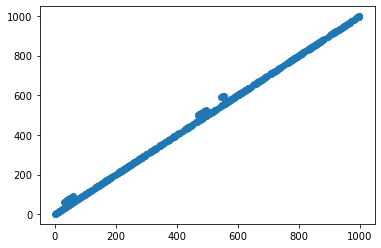

In [63]:
import matplotlib.pyplot as plt
plt.scatter(*zip(*cache))
plt.show()

(array([434.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,  20.,   0.,  12.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          3.]),
 array([ 1.  ,  1.45,  1.9 ,  2.35,  2.8 ,  3.25,  3.7 ,  4.15,  4.6 ,
         5.05,  5.5 ,  5.95,  6.4 ,  6.85,  7.3 ,  7.75,  8.2 ,  8.65,
         9.1 ,  9.55, 10.  , 10.45, 10.9 , 11.35, 11.8 , 12.25, 12.7 ,
        13.15, 13.6 , 14.05, 14.5 , 14.95, 15.4 , 15.85, 16.3 , 16.75,
        17.2 , 17.65, 18.1 , 18.55

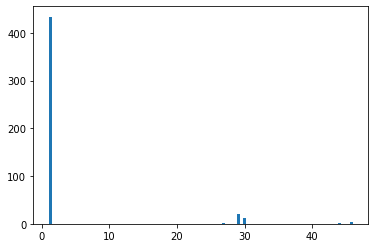

In [70]:
deltas = [abs(i1-i2) for i1, i2 in cache]
plt.hist(deltas, bins=100)

### Similar structures seem to be embedded next to each other in string embed. Let's try the new lru_cache algorithm

In [1]:
from tscode.embedder import Embedder

embedder = Embedder(r'C:\Users\Nik\Desktop\nt383\P1\string_embed_mock.txt', stamp='debug')
embedder.objects[0].atomcoords = embedder.objects[0].atomcoords[0:20]
embedder.objects[1].atomcoords = embedder.objects[1].atomcoords[0:20]


             ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
            ╱───────────────────────────────────╲
           ╱▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒╲
       ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒
    ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒ 
   ▒░████████╗░██████╗░█████╗░░█████╗░██████╗░███████╗░░░▒
   ▒░╚══██╔══╝██╔════╝██╔══██╗██╔══██╗██╔══██╗██╔════╝░░░▒ 
   ▒░░░░██║░░░╚█████╗░██║░░╚═╝██║░░██║██║░░██║█████╗░░░░░▒  
   ▒░░░░██║░░░░╚═══██╗██║░░██╗██║░░██║██║░░██║██╔══╝░░░░░▒   
    ▒░░░██║░░░██████╔╝╚█████╔╝╚█████╔╝██████╔╝███████╗░░░▒    
   ╱ ▒░░╚═╝░░░╚═════╝░░╚════╝░░╚════╝░╚═════╝░╚══════╝░░▒ ╲
  ╱   ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒   ╲
 ╱    ▒░░╔══════════════════════════════════════════╗░░▒    ╲
 ╲╲    ▒░║  Transition State Conformational Docker  ║░▒    ╱╱   
  ╲╲   ▒░║        nicolo.tampellini@yale.edu        ║░▒   ╱╱    
   ╲╲  ▒░║                                          ║░▒  ╱╱         
    ╲╲ ▒░║     Version    >          0.2.0        

In [2]:
embedder.run()

--> Input structures & reactive indexes data:

    1. hemiacetals_Ph_confs.xyz -> 45 atoms, 50 conformers
        33 -> H(Single Bond, 0.85 A, 1 center)

    2. hemiacetals_Ph_confs.xyz -> 45 atoms, 50 conformers
        33 -> H(Single Bond, 0.85 A, 1 center)

--> Atom pairings imposed are 1: [[33, 78]] (Cumulative index numbering)

    1. a - Constraint - 1.7 A
       Index 33 (hydrogen) on hemiacetals_Ph_confs
       Index 33 (hydrogen) on hemiacetals_Ph_confs

--> Calculation options used were:
    - calculator                : MOPAC
    - clash_thresh              : 1.5
    - csearch_aug               : True
    - ff_calc                   : OB
    - ff_level                  : MMFF94
    - ff_opt                    : True
    - kcal_thresh               : 20
    - max_clashes               : 0
    - max_confs                 : 1000
    - max_newbonds              : 0
    - only_refined              : False
    - optimization              : True
    - rmsd                      : 0.

: 

: 

In [2]:
from tscode.utils import write_xyz

with open('some_confs.xyz', 'w') as f:
    for i, s in enumerate(embedder.objects[0].atomcoords):
        write_xyz(s, embedder.objects[0].atomnos, f)

i

19

### Let's look at some conformers

In [1]:
from tscode.utils import read_xyz
from tscode.algebra import norm_of
import matplotlib.pyplot as plt

data = read_xyz(r'C:\Users\Nik\Desktop\P2\urea\TSCoDe_poses_P2_urea_lead.xyz')
dists = [norm_of(c[35]-c[138]) for c in data.atomcoords]

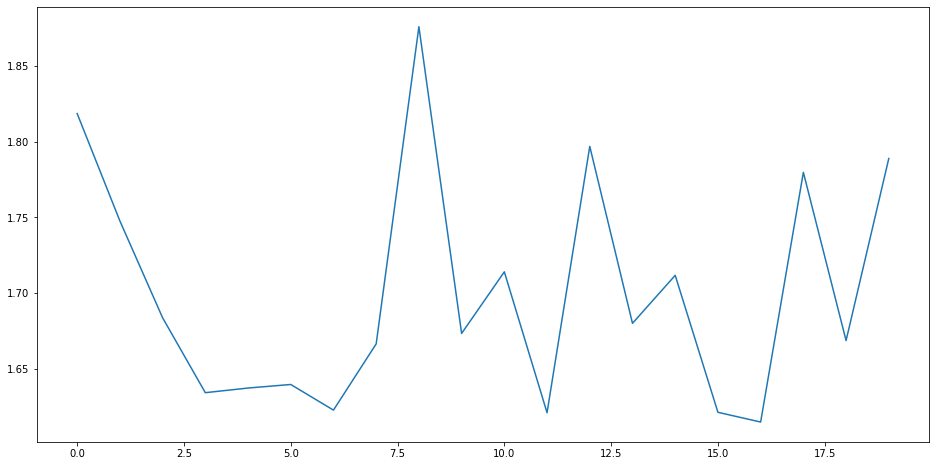

In [4]:
fig = plt.figure(figsize=(16,8))
plt.plot(dists[0:20], label='35 138 distance')

In [5]:
import numpy as np
np.mean(dists)

1.7502885928319463

(array([ 16., 107., 153., 108., 169., 170., 124.,  16.,   0.,   1.]),
 array([1.56508011, 1.61023834, 1.65539656, 1.70055479, 1.74571301,
        1.79087124, 1.83602946, 1.88118768, 1.92634591, 1.97150413,
        2.01666236]),
 <BarContainer object of 10 artists>)

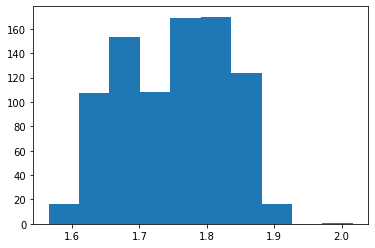

In [6]:
plt.hist(dists)

In [9]:
from tscode.hypermolecule_class import align_structures
from tscode.utils import write_xyz

with open('aligned.xyz', 'w') as f:
    for c in align_structures(data.atomcoords, (0, 1, 2, 3, 4)):
        write_xyz(c, data.atomnos, f)

### pairing thing

In [23]:
import re
def x(reactive_atoms):
    numbers = [int(re.sub('[^0-9]', '', i)) for i in reactive_atoms]
    letters = [re.sub('[^a-z]', '', i) for i in reactive_atoms]
    count = [letters.count(l) for l in letters]
    return tuple([n for n, c in zip(numbers, count) if c == 1])

def old(reactive_atoms):
    return tuple([int(re.sub('[^0-9]', '', i)) for i in reactive_atoms])

In [22]:
x('32a 16b 12a'.split())

(16,)

In [25]:
old('32a'.split())

(32,)

## PES

In [12]:
from tscode.utils import read_xyz
from tscode.calculators._xtb import xtb_opt, xtb_get_free_energy
import os
os.chdir('/mnt/c/Users/Nik/Desktop/maleimide/energetics')

meoh = read_xyz('MeOH.xyz')
sm = read_xyz('sm.xyz')
p = read_xyz('p.xyz')
hemi = read_xyz('hemiacetal.xyz')

In [19]:
meoh_opt, meoh_e, _ = xtb_opt(meoh.atomcoords[0], meoh.atomnos, solvent='ch2cl2')

In [20]:
sm_opt, sm_e, _ = xtb_opt(sm.atomcoords[0], sm.atomnos, solvent='ch2cl2')

In [21]:
p_opt, p_e, _ = xtb_opt(p.atomcoords[0], p.atomnos, solvent='ch2cl2')

In [22]:
hemi_opt, hemi_e, _ = xtb_opt(hemi.atomcoords[0], hemi.atomnos, solvent='ch2cl2')

In [25]:
m = min([p_e+meoh_e, sm_e, hemi_e])
print(f'sm - {sm_e-m} kcal/mol')
print(f'hemi - {hemi_e-m} kcal/mol')
print(f'p+meoh - {(p_e+meoh_e)-m}')

sm - 4.594344331744651 kcal/mol
hemi - 0.0 kcal/mol
p+meoh - 10.064930831780657


In [17]:
meoh_fe = xtb_get_free_energy(meoh_opt, meoh.atomnos, solvent='ch2cl2')
print('1/4')
sm_fe = xtb_get_free_energy(sm_opt, sm.atomnos, solvent='ch2cl2')
print('2/4')
p_fe = xtb_get_free_energy(p_opt, p.atomnos, solvent='ch2cl2')
print('3/4')
hemi_fe = xtb_get_free_energy(hemi_opt, hemi.atomnos, solvent='ch2cl2')
print('4/4')

1/4
2/4
3/4
4/4
meoh - 43821.488511890995 kcal/mol
sm - 3.0178091661582584 kcal/mol
p - 5143.317448615453 kcal/mol
hemi - 0.0 kcal/mol


In [28]:

m = min([p_fe+meoh_fe, sm_fe, hemi_fe])
print(f'sm - {sm_fe-m} kcal/mol')
print(f'hemi - {hemi_fe-m} kcal/mol')
print(f'p+meoh - {(p_fe+meoh_fe)-m}')

sm - 7.360036694226437 kcal/mol
hemi - 4.342227528068179 kcal/mol
p+meoh - 0.0


In [18]:
from tscode.utils import write_xyz

for s, a, n in zip((meoh_opt, sm_opt, p_opt, hemi_opt), (meoh.atomnos, sm.atomnos, p.atomnos, hemi.atomnos), ('meoh_opt', 'sm_opt', 'p_opt', 'hemi_opt')):
    with open(f'{n}.xyz', 'w') as f:
        write_xyz(s, a, f)

In [1]:
## deleteme
from tscode.utils import read_xyz, write_xyz
from tscode.algebra import norm_of
data = read_xyz(r'C:\Users\Nik\Desktop\TSCoDe_checkpoint_lead_attack.xyz')
len(data.atomcoords)

228

In [15]:
tups = [(i, norm_of(c[48]-c[133])) for i, c in enumerate(data.atomcoords)]
i, d = zip(*sorted(tups, key=lambda x: x[1]))
i[0]

224

In [17]:
from tscode.hypermolecule_class import align_structures

data.atomcoords = align_structures(data.atomcoords, indexes=[48, 133])
with open('close.xyz', 'w') as f:
    for ids, dd in zip(i, d):
        write_xyz(data.atomcoords[ids], data.atomnos, f, f'd={dd} A')

## Let's use malloc to see if we have a memory leak

In [2]:
import tracemalloc

from tscode.embedder import Embedder
from tscode.clustered_csearch import csearch

# embedder = Embedder(r'C:\Users\Nik\Desktop\debug\malloc\input', stamp='debug')
embedder = Embedder(r'/mnt/c/Users/Nik/Desktop/debug/malloc/input', stamp='debug')
embedder.objects[0].atomcoords.shape


             ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
            ╱───────────────────────────────────╲
           ╱▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒╲
       ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒
    ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒ 
   ▒░████████╗░██████╗░█████╗░░█████╗░██████╗░███████╗░░░▒
   ▒░╚══██╔══╝██╔════╝██╔══██╗██╔══██╗██╔══██╗██╔════╝░░░▒ 
   ▒░░░░██║░░░╚█████╗░██║░░╚═╝██║░░██║██║░░██║█████╗░░░░░▒  
   ▒░░░░██║░░░░╚═══██╗██║░░██╗██║░░██║██║░░██║██╔══╝░░░░░▒   
    ▒░░░██║░░░██████╔╝╚█████╔╝╚█████╔╝██████╔╝███████╗░░░▒    
   ╱ ▒░░╚═╝░░░╚═════╝░░╚════╝░░╚════╝░╚═════╝░╚══════╝░░▒ ╲
  ╱   ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▒   ╲
 ╱    ▒░░╔══════════════════════════════════════════╗░░▒    ╲
 ╲╲    ▒░║  Transition State Conformational Docker  ║░▒    ╱╱   
  ╲╲   ▒░║        nicolo.tampellini@yale.edu        ║░▒   ╱╱    
   ╲╲  ▒░║                                          ║░▒  ╱╱         
    ╲╲ ▒░║     Version    >          0.3.0        

(2, 105, 3)

In [8]:
# does not seem to leak in the conformational search, maybe it does in the augmentation part
from tscode.run import RunEmbedding
import numpy as np
mol = embedder.objects[0]

embedder.options.ff_calc = 'XTB'
embedder.options.ff_level = 'GFN-FF'

re = RunEmbedding(embedder)
re.structures = np.array(embedder.objects[0].atomcoords)
re.atomnos = mol.atomnos
re.constrained_indexes = np.array([[]])
re.energies = np.array([])

re.structures.shape

(2, 105, 3)

In [9]:

re.csearch_augmentation(text='warmup', max_structs=100)

--> Performing conformational augmentation of TS candidates warmup
Performing CSearch 2/2  |##################################################| 100.0%           )
Conformational augmentation completed - generated 50 new conformers (1.247 s)



In [11]:
tracemalloc.start()
s = tracemalloc.take_snapshot()

############################################################

try:
    # re.csearch_augmentation(text='tracemalloc', max_structs=100)
    re.csearch_augmentation_routine()
except KeyboardInterrupt:
    pass

############################################################

lines = []
top_stats = tracemalloc.take_snapshot().compare_to(s, 'lineno')
for stat in top_stats[:5]:
    lines.append(str(stat))
print("\n".join(lines))

--> Performing conformational augmentation of TS candidates (step 1/3)
Performing CSearch 103/103  |##################################################| 100.0%           ted)
Conformational augmentation completed - generated 102 new conformers (1 m 13.395 s)


--> Checkpoint output - Wrote 205 TS structures to TSCoDe_checkpoint_debug.xyz file before FF optimization.

--> Structure optimization (GFN-FF/ch2cl2 level via XTB)
/home/linux/miniconda3/lib/python3.8/copy.py:230: size=806 KiB (+289 KiB), count=4326 (+1551), average=191 B
<__array_function__ internals>:5: size=849 KiB (+268 KiB), count=105 (+24), average=8275 B
/home/linux/miniconda3/lib/python3.8/copy.py:227: size=292 KiB (+106 KiB), count=4677 (+1701), average=64 B
/home/linux/miniconda3/lib/python3.8/tracemalloc.py:532: size=193 KiB (+106 KiB), count=3583 (+1898), average=55 B
/home/linux/miniconda3/lib/python3.8/site-packages/pygments/lexer.py:511: size=7328 B (-51.4 KiB), count=121 (-855), average=61 B


In [14]:
from memory_profiler import profile

@profile
def wrapper(*args, **kwargs):
    return re.csearch_augmentation_routine()
    
try:
    # re.csearch_augmentation(text='tracemalloc', max_structs=100)
    wrapper()
except KeyboardInterrupt:
    pass

ERROR: Could not find file /tmp/ipykernel_941/3919469545.py
--> Performing conformational augmentation of TS candidates (step 1/3)


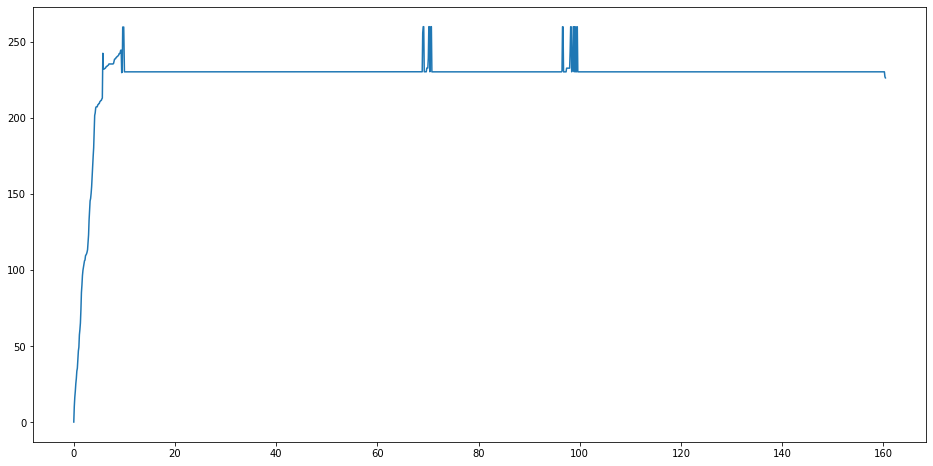

In [19]:
import matplotlib.pyplot as plt

with open(r'/mnt/c/Users/Nik/Desktop/Coding/TSCoDe/tscode/mprofile_20220831160841.dat', 'r') as f:
    lines = f.readlines()

T, Y = [], []
for line in lines[1:]:
    _, y, t = line.split()
    Y.append(float(y))
    T.append(float(t))

T = np.array(T)
T -= np.min(T)

fig = plt.figure(figsize=(16,8))
plt.plot(T, Y)

In [20]:
## Crazy idea: average angle in embedded structures dictates axis?
from tscode.utils import read_xyz

data = read_xyz(r'/mnt/c/Users/Nik/Desktop/lead_attack/TSCoDe_checkpoint_lead_attack.xyz')
data.atomcoords.shape

(249, 154, 3)

In [21]:
from tscode.algebra import dihedral
import numpy as np
import matplotlib.pyplot as plt
angles = np.array([dihedral(c[[107, 108, 131, 114]]) for c in data.atomcoords])
angles[0:5]

array([35.69588422, 46.3243366 , 41.08701178, 41.30324427, 50.4724347 ])

(array([25.,  5.,  0.,  0.,  0., 10., 84., 99., 25.,  1.]),
 array([-65.70397612, -48.26262328, -30.82127044, -13.3799176 ,
          4.06143524,  21.50278808,  38.94414092,  56.38549376,
         73.8268466 ,  91.26819944, 108.70955227]),
 <BarContainer object of 10 artists>)

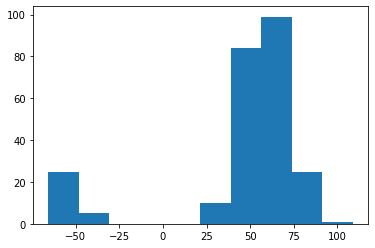

In [22]:
plt.hist(angles)

In [23]:
np.mean(angles)

44.24234563191296

In [25]:
weights = np.linspace(1, 0.5, num=len(angles))
np.mean([a*w for a, w in zip(angles, weights)])

32.76020239664593

In [11]:
from tscode.utils import rotate_dihedral
import numpy as np

a = np.array([[1, 2, 3],
              [2, 3, 4],
              [3, 4, 5],
              [4, 5, 6],])

b = rotate_dihedral(a.copy(), [0, 1, 2,3], 90)
b

array([[0, 1, 2],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

In [12]:
a

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])